# Bike Sharing Assignment

In this notebook we are going to analyze the data given in data/day.csv from linear regression perspective. The end goal is to build multiple linear regression model for the target variable "cnt".

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading data from csv file
data = pd.read_csv("data/day.csv")
data.head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
6,7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510
7,8,08-01-2018,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,68,891,959
8,9,09-01-2018,1,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,54,768,822
9,10,10-01-2018,1,0,1,0,1,1,1,6.184153,7.54440,48.2917,14.958889,41,1280,1321


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Data cleanup

In [4]:
# dropping unimportant columns 
data = data.drop(["instant"],axis=1)
data = data.drop(["casual"],axis=1)
data = data.drop(["registered"],axis=1)

In [5]:
# find out any blank / null cells
print(f"Null/blank rows : {data.isna().any(axis=1).sum()}")
print(f"Null/blank cols : {data.isna().any(axis=0).sum()}")

Null/blank rows : 0
Null/blank cols : 0


In [6]:
print(f"Weekend and holiday : {data.loc[(data['holiday'] == 1) & (data['workingday'] == 0)]['holiday'].count()}")
print(f"Just Weekends : {data.loc[(data['holiday'] == 0) & (data['workingday'] == 0)]['holiday'].count()}")
print(f"Workdays : {data.loc[(data['workingday'] == 1)]['holiday'].count()}")


Weekend and holiday : 21
Just Weekends : 210
Workdays : 499


## Data Preparation

In [7]:
data['season'] = data['season'].apply(lambda s : "spring" if s == 1 else "summer" if s == 2 else "fall" if s == 3 else "winter")
data['weathersit'] = data['weathersit'].apply(lambda w : "clear" if w == 1 else "misty" if w == 2 else "light_snow_rain" if w == 3 else "heavy_snow_rain")
# setting year column with appropriate years (0 is 2018, 1 is 2019)..
data["actual_yr"] = data["yr"]+2018
data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,actual_yr
0,01-01-2018,spring,0,1,0,6,0,misty,14.110847,18.18125,80.5833,10.749882,985,2018
1,02-01-2018,spring,0,1,0,0,0,misty,14.902598,17.68695,69.6087,16.652113,801,2018
2,03-01-2018,spring,0,1,0,1,1,clear,8.050924,9.47025,43.7273,16.636703,1349,2018
3,04-01-2018,spring,0,1,0,2,1,clear,8.200000,10.60610,59.0435,10.739832,1562,2018
4,05-01-2018,spring,0,1,0,3,1,clear,9.305237,11.46350,43.6957,12.522300,1600,2018


In [8]:
print(data["season"].unique())
print(data["weathersit"].unique())

['spring' 'summer' 'fall' 'winter']
['misty' 'clear' 'light_snow_rain']


## Data Visualization

<Axes: xlabel='actual_yr', ylabel='cnt'>

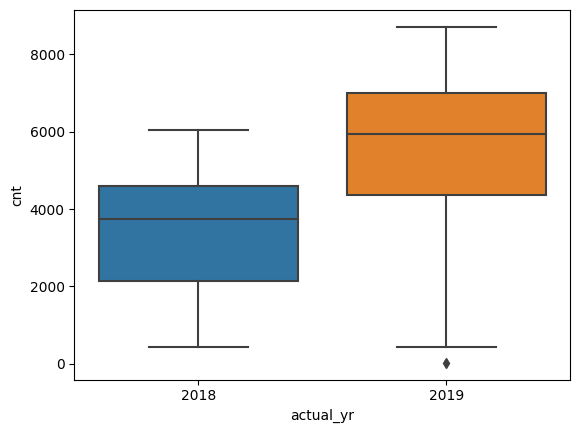

In [9]:
sns.boxplot(x='actual_yr', y='cnt',data=data)

<Axes: xlabel='mnth', ylabel='cnt'>

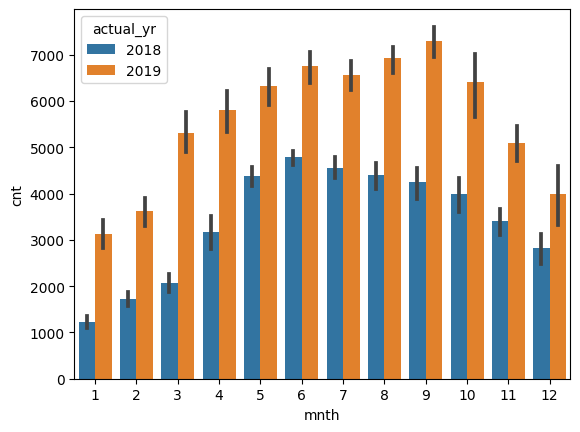

In [10]:
sns.barplot(x='mnth', y='cnt',data=data, hue='actual_yr')
# There is  seasonality per month in each year.
# since the trend is similar, we can try to find correlation between month and the cnt

<Axes: xlabel='mnth', ylabel='cnt'>

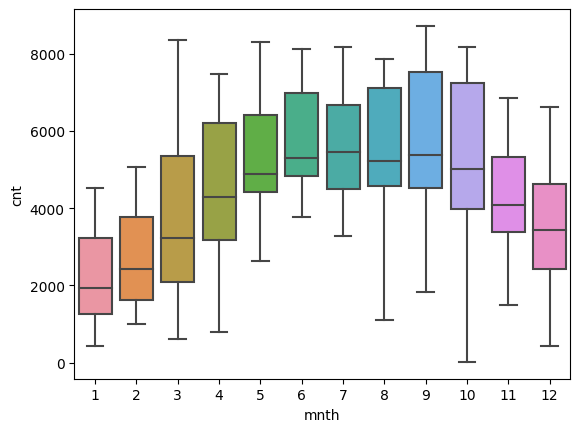

In [11]:
sns.boxplot(x='mnth', y='cnt',data=data)

<Axes: xlabel='season', ylabel='cnt'>

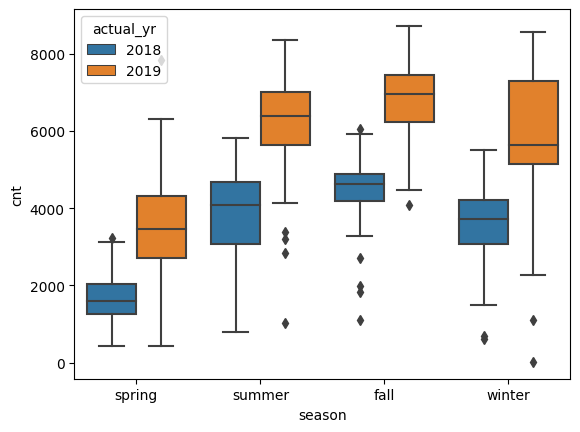

In [12]:
sns.boxplot(x='season', y='cnt',data=data, hue="actual_yr")

<Axes: xlabel='weathersit', ylabel='cnt'>

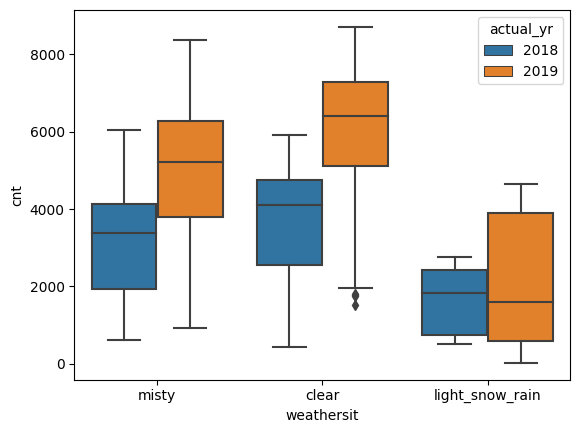

In [13]:
sns.boxplot(x='weathersit', y='cnt',data=data, hue="actual_yr")

<Axes: xlabel='workingday', ylabel='cnt'>

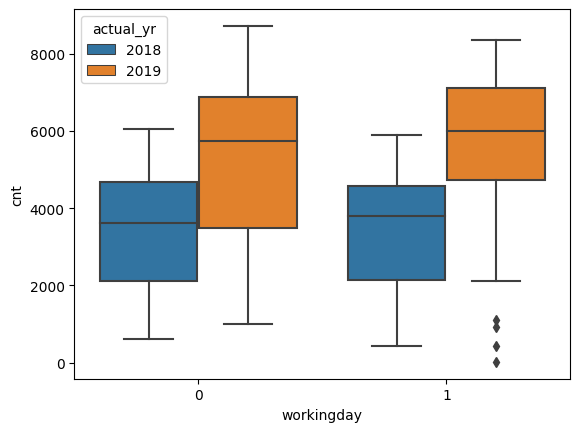

In [14]:
sns.boxplot(x='workingday', y='cnt',data=data, hue="actual_yr")

<Axes: xlabel='holiday', ylabel='cnt'>

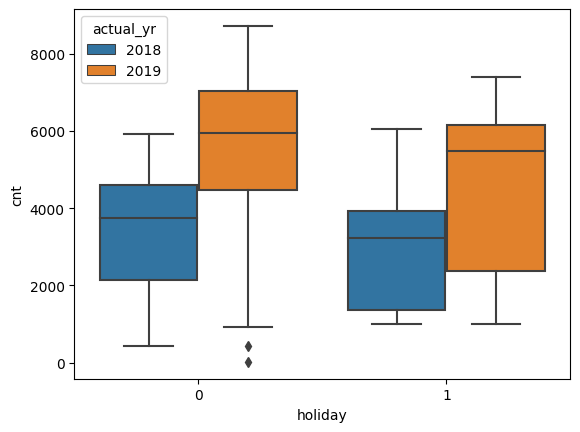

In [15]:
sns.boxplot(x='holiday', y='cnt',data=data, hue="actual_yr")

<Axes: xlabel='weekday', ylabel='cnt'>

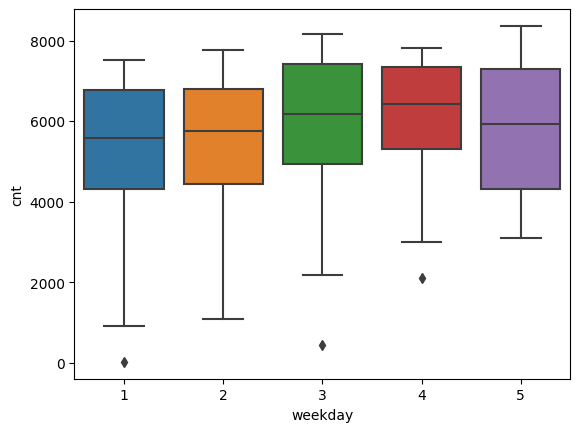

In [16]:
sns.boxplot(x='weekday', y='cnt',data=data[(data['workingday']==1) & (data['actual_yr'] == 2019) ])

<Axes: xlabel='weekday', ylabel='cnt'>

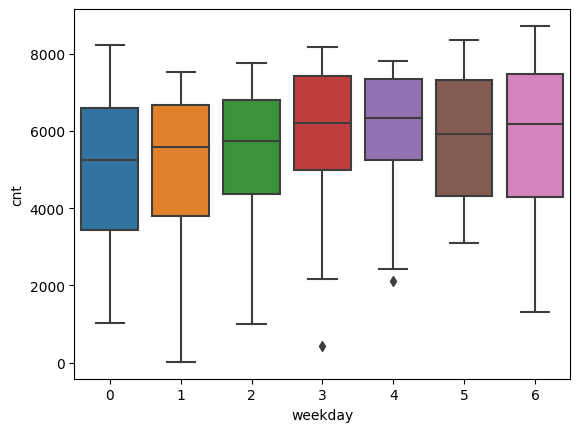

In [17]:
sns.boxplot(x='weekday', y='cnt',data=data[(data['actual_yr'] == 2019) ])

<Axes: xlabel='weekday', ylabel='cnt'>

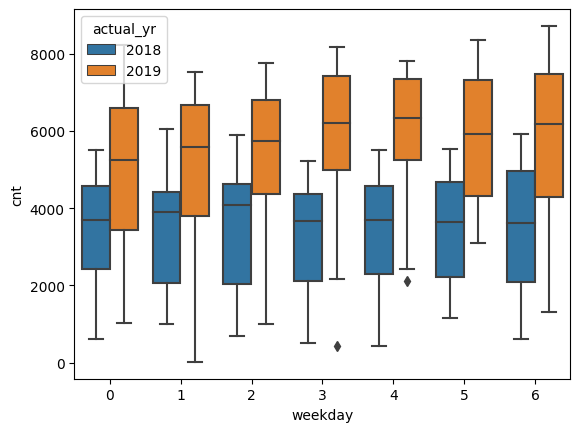

In [18]:
sns.boxplot(x='weekday', y='cnt',data=data, hue="actual_yr")

In [19]:
data[data['actual_yr']==2018][['weekday','cnt']].corr()

,weekday,cnt
weekday,1.000000,-0.004396
cnt,-0.004396,1.000000


In [20]:
data[data['actual_yr']==2019][['weekday','cnt']].corr()

,weekday,cnt
weekday,1.00000,0.15707
cnt,0.15707,1.00000


In [21]:
data[['holiday','workingday','cnt']].corr()

,holiday,workingday,cnt
holiday,1.000000,-0.252948,-0.068764
workingday,-0.252948,1.000000,0.062542
cnt,-0.068764,0.062542,1.000000


In [22]:
data['windspeed'].describe()

count    730.000000
mean      12.763620
std        5.195841
min        1.500244
25%        9.041650
50%       12.125325
75%       15.625589
max       34.000021
Name: windspeed, dtype: float64

In [23]:
data['hum'].describe()

count    730.000000
mean      62.765175
std       14.237589
min        0.000000
25%       52.000000
50%       62.625000
75%       72.989575
max       97.250000
Name: hum, dtype: float64

In [24]:
data[['windspeed','hum','cnt']].corr()

,windspeed,hum,cnt
windspeed,1.000000,-0.248506,-0.235132
hum,-0.248506,1.000000,-0.098543
cnt,-0.235132,-0.098543,1.000000


In [25]:
data[['actual_yr','cnt']].corr()

,actual_yr,cnt
actual_yr,1.000000,0.569728
cnt,0.569728,1.000000


In [26]:
data[['temp','atemp','cnt']].corr()

,temp,atemp,cnt
temp,1.000000,0.991696,0.627044
atemp,0.991696,1.000000,0.630685
cnt,0.627044,0.630685,1.000000


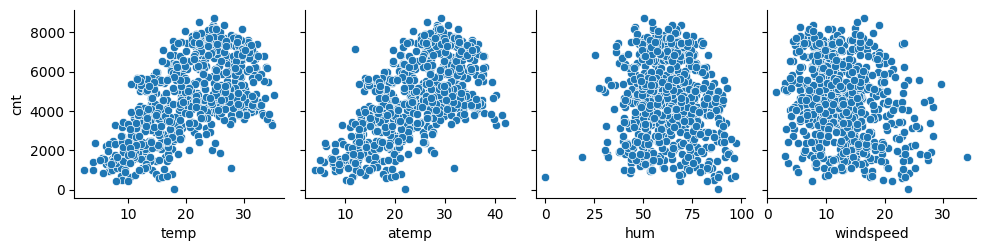

In [27]:
sns.pairplot(data=data, x_vars=['temp','atemp','hum','windspeed'], y_vars=['cnt'])

##### Pair Plot Summary

temp and atemp both seemt to have clear correlation with cnt whereas hum and windspeed are not much correlated. The pair plots of temp and atemp are pretty much same because they have high level of colinearity with each other.

<Axes: xlabel='atemp', ylabel='cnt'>

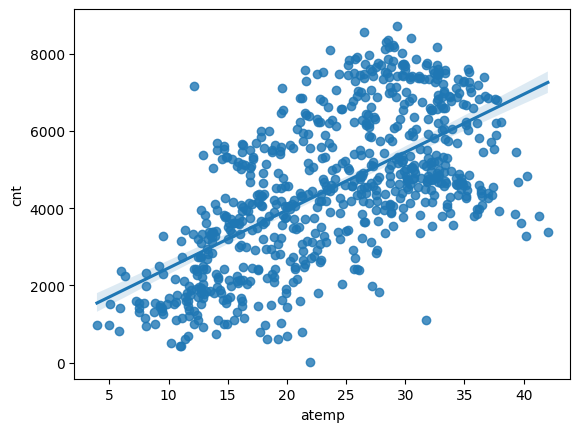

In [28]:
sns.regplot(data=data,x='atemp',y='cnt')

In [29]:
# following is to make sure our hunch of temp and atemp having high multicolinearity is correct
vif=pd.DataFrame()
temp_atemp_df = data[['temp','atemp']]
vif['Features']=temp_atemp_df.columns
vif['VIF']= [variance_inflation_factor(temp_atemp_df.values,i) for i in range(temp_atemp_df.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

# and it did come out as 417 which is extremly high and only one of them should be used

,Features,VIF
0,temp,417.61
1,atemp,417.61


### Visual Study Summary
* There is a clear evidence that usage/demand has gone up in 2019 compared to 2018
* The usage is correlated to the month of a year, and the pattern is cyclical at year level. In other words, the usage goes up in the mid of year and remains down / less in the end and begining of the year.
* Season definately makes and impact on the usage, however since we follow solar calendar, they do coincide with months, and hence there might **possible correlation** between season and months, if need to check.
* In 2018, there is not much correlation between the usage count and week-day (regardless of workday or weekend/holiday), however in 2019, there is a minor relation with the week-day being other than sunday (no. 0). We will have to verify this.
* temperature (temp) and feels-like temperature (atemp) are pretty much same and atemp is better correlated to cnt, so we will just use atemp for our analysis.
* The other numerical data points like humidity and windspeed don't seem to have clear correlation with cnt based on the pairplot.


In [30]:
data = pd.get_dummies(data,columns=["season"], drop_first=True,prefix="s")
data = pd.get_dummies(data,columns=["weathersit"], drop_first=True,prefix="w")

In [31]:
data.head()

,dteday,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,actual_yr,s_spring,s_summer,s_winter,w_light_snow_rain,w_misty
0,01-01-2018,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,985,2018,1,0,0,0,1
1,02-01-2018,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,2018,1,0,0,0,1
2,03-01-2018,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,2018,1,0,0,0,0
3,04-01-2018,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,1562,2018,1,0,0,0,0
4,05-01-2018,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,1600,2018,1,0,0,0,0


# Model Training

## Model without months

In [32]:
# Take the important columns for model training

model_1 = data[['yr','s_spring','s_summer','s_winter','w_light_snow_rain','w_misty', 'atemp','hum','windspeed', 'workingday','cnt']]

In [33]:

## Splitting train and test dataset

(m1_train,m1_test) = train_test_split(model_1,train_size=0.7,random_state=100)

In [34]:
m1_train.describe()

,yr,s_spring,s_summer,s_winter,w_light_snow_rain,w_misty,atemp,hum,windspeed,workingday,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.243137,0.247059,0.247059,0.029412,0.345098,23.500287,63.123710,12.834912,0.676471,4485.337255
std,0.500429,0.429398,0.431725,0.431725,0.169124,0.475867,8.090963,14.153170,5.292031,0.468282,1950.666077
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.953480,0.000000,2.834381,0.000000,22.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.603063,52.270825,9.041918,0.000000,3120.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.131150,63.437500,12.083182,1.000000,4530.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,30.177700,73.250025,15.750879,1.000000,5973.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,42.044800,97.041700,34.000021,1.000000,8714.000000


In [35]:
m1_test.describe()

,yr,s_spring,s_summer,s_winter,w_light_snow_rain,w_misty,atemp,hum,windspeed,workingday,cnt
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.254545,0.263636,0.236364,0.027273,0.318182,24.250312,61.934025,12.598352,0.700000,4560.559091
std,0.500809,0.436599,0.441609,0.425817,0.163248,0.466833,8.281075,14.429542,4.973534,0.459303,1904.968544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.941955,25.416700,1.500244,0.000000,441.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.090025,51.354200,9.031466,0.000000,3312.750000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.700000,60.708350,12.188004,1.000000,4582.500000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,31.124313,72.179375,15.385361,1.000000,5913.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.318550,97.250000,27.999836,1.000000,8395.000000


In [36]:
scaler = MinMaxScaler()
num_vars = ['atemp','hum','windspeed','cnt']
m1_train[num_vars] = scaler.fit_transform(m1_train[num_vars])

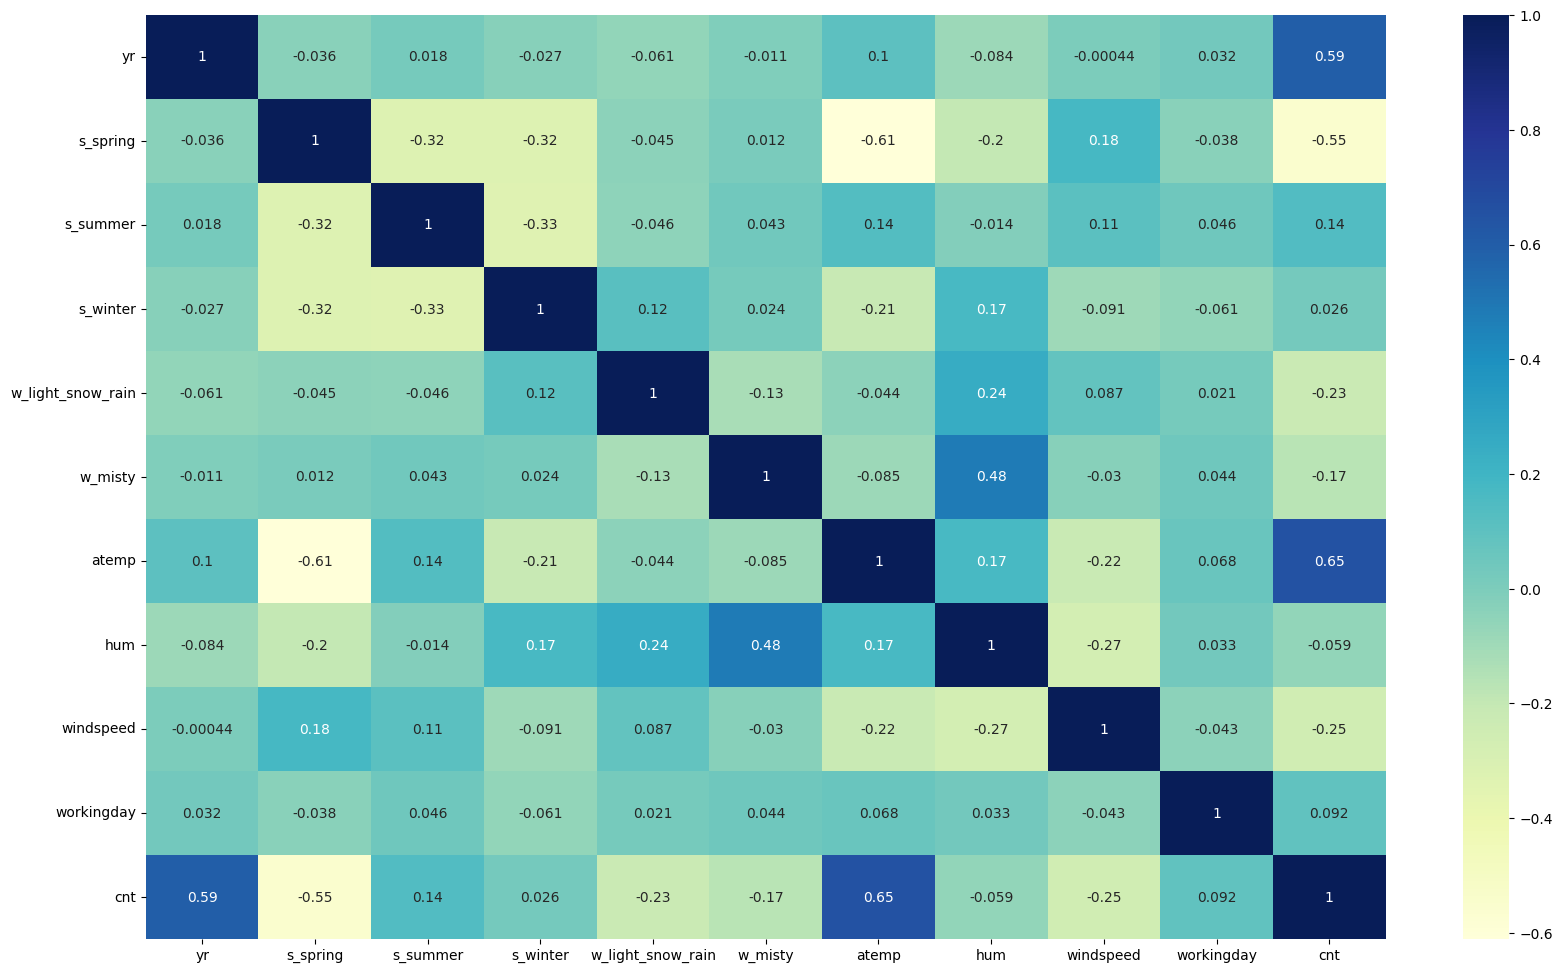

In [37]:
plt.figure(figsize=(20,12))
sns.heatmap(m1_train.corr(),annot=True,cmap="YlGnBu")
plt.show()

### With two highly correlated columns (LR Model A)

From the above correlation matrix : yr, atemp, and s_spring are having strong correlation with cnt followed by windspead, weather columns.

In [38]:
# lets add s_spring to see whether it improves the model stats
X_m1_train = m1_train[['yr','atemp','s_spring']]
y_m1_train = m1_train['cnt']

In [39]:
X_m1_train_sm = sm.add_constant(X_m1_train)
lr = sm.OLS(y_m1_train,X_m1_train_sm)
lr_model = lr.fit()
lr_model.params

const       0.193383
yr          0.240728
atemp       0.451964
s_spring   -0.140104
dtype: float64

In [40]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     484.6
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          2.56e-148
Time:                        20:20:07   Log-Likelihood:                 384.19
No. Observations:                 510   AIC:                            -760.4
Df Residuals:                     506   BIC:                            -743.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1934      0.019     10.214      0.000       0.156       0.231
yr             0.2407      0.010     23.618      0.000       0.221       0.261
atemp          0.4520      0.030     14.908      0.000       0.392       0.512
s_spring      -0.1401      0.015     -9.388      0.000      -0.169      -0.111
==============================================================================
Omnibus:                      107.311   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.934
Skew:                          -1.007   Prob(JB):                     2.24e-67
Kurtosis:                       6.223   Cond. No.                         9.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Summary
got R² of 0.742 which is not bad but not good either. lets continue adding more variables based on their correlation with cnt.

### With additional columns of weather and spring season columns (LR Model B)

From the above correlation matrix : yr and atemp are having strong correlation with cnt followed by windspead, weather columns and s_spring.



In [41]:
# lets add  weather columns and windspeed to see whether it makes any difference
X_m1_train = m1_train[['yr','atemp','s_spring', 'w_light_snow_rain','w_misty','windspeed']]
y_m1_train = m1_train['cnt']
X_m1_train_sm = sm.add_constant(X_m1_train)
lr = sm.OLS(y_m1_train,X_m1_train_sm)
lr_model = lr.fit()
lr_model.params

const                0.310191
yr                   0.236811
atemp                0.388947
s_spring            -0.152877
w_light_snow_rain   -0.267825
w_misty             -0.074380
windspeed           -0.142822
dtype: float64

In [42]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     360.4
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          1.55e-178
Time:                        20:20:07   Log-Likelihood:                 464.12
No. Observations:                 510   AIC:                            -914.2
Df Residuals:                     503   BIC:                            -884.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3102      0.020     15.621      0.000       0.271       0.349
yr                    0.2368      0.009     27.047      0.000       0.220       0.254
atemp                 0.3889      0.026     14.687      0.000       0.337       0.441
s_spring             -0.1529      0.013    -11.847      0.000      -0.178      -0.128
w_light_snow_rain    -0.2678      0.026    -10.222      0.000      -0.319      -0.216
w_misty              -0.0744      0.009     -8.022      0.000      -0.093      -0.056
windspeed            -0.1428      0.026     -5.413      0.000      -0.195      -0.091
==============================================================================
Omnibus:                       63.325   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.581
Skew:                          -0.641   Prob(JB):                     9.97e-35
Kurtosis:                       5.392   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF
Finding VIF to make sure that there is not multicollinearity among columns.

In [43]:
vif=pd.DataFrame()
vif['Features']=X_m1_train.columns
vif['VIF']= [variance_inflation_factor(X_m1_train.values,i) for i in range(X_m1_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
5,windspeed,3.63
1,atemp,3.48
0,yr,2.02
2,s_spring,1.50
4,w_misty,1.46
3,w_light_snow_rain,1.06


#### Summary

The VIF of all the columns is less than 5, which suggests that there is no multicollinearity.

The model's R² is 0.811 which is pretty good, and all the columns are significant given their p-values are less than 0.05. 

This model uses **6 independent variables** and a constant


### With all independent columns (LR Model C)

Just to ensure that we are not missing on any other important independent variable, this model is trained on all 10 independent variables.

In [44]:
# lets add all columns to see whether it makes any difference
y_m1_train = m1_train['cnt']
X_m1_train = m1_train.drop('cnt',axis=1)
X_m1_train_sm = sm.add_constant(X_m1_train)
X_m1_train_sm.head()

,const,yr,s_spring,s_summer,s_winter,w_light_snow_rain,w_misty,atemp,hum,windspeed,workingday
576,1.0,1,0,0,0,0,0,0.766351,0.725633,0.264686,1
426,1.0,1,1,0,0,0,1,0.438975,0.640189,0.255342,0
728,1.0,1,1,0,0,0,0,0.200348,0.498067,0.663106,0
482,1.0,1,0,1,0,0,1,0.391735,0.504508,0.188475,0
111,1.0,0,0,1,0,0,1,0.318819,0.751824,0.380981,1


In [45]:
lr = sm.OLS(y_m1_train,X_m1_train_sm)
lr_model = lr.fit()
lr_model.params

const                0.295167
yr                   0.231747
s_spring            -0.097086
s_summer             0.028750
s_winter             0.066348
w_light_snow_rain   -0.235092
w_misty             -0.052773
atemp                0.494302
hum                 -0.139921
windspeed           -0.163101
workingday           0.023024
dtype: float64

In [46]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     230.4
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          7.72e-180
Time:                        20:20:07   Log-Likelihood:                 478.97
No. Observations:                 510   AIC:                            -935.9
Df Residuals:                     499   BIC:                            -889.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2952      0.036      8.179      0.000       0.224       0.366
yr                    0.2317      0.009     26.945      0.000       0.215       0.249
s_spring             -0.0971      0.020     -4.820      0.000      -0.137      -0.058
s_summer              0.0287      0.014      2.103      0.036       0.002       0.056
s_winter              0.0663      0.016      4.032      0.000       0.034       0.099
w_light_snow_rain    -0.2351      0.028     -8.408      0.000      -0.290      -0.180
w_misty              -0.0528      0.011     -4.747      0.000      -0.075      -0.031
atemp                 0.4943      0.036     13.771      0.000       0.424       0.565
hum                  -0.1399      0.040     -3.521      0.000      -0.218      -0.062
windspeed            -0.1631      0.027     -5.973      0.000      -0.217      -0.109
workingday            0.0230      0.009      2.526      0.012       0.005       0.041
==============================================================================
Omnibus:                       67.128   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.685
Skew:                          -0.600   Prob(JB):                     1.78e-46
Kurtosis:                       5.911   Cond. No.                         20.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Summary

This model has pushed R² just a few decimals up (0.822 vs 0.811) has two independent variables (s_summer, and workingday) having higher p-values.

**LR Model B** is a better model given it uses much lesser variables and with similar R² score.

### Removed insignificant independent variables (LR Model D)

In above model (LR Model C), s_summer and workingday have higher p values and hence they are not significant to model, so lets drop them and try again

In [47]:
# in above model, s_summer and workingday have higher p values and hence they are not significant to model, so lets drop them and try again
X_m1_train = m1_train.drop(columns=['cnt','s_summer','workingday'],axis=1)
X_m1_train_sm = sm.add_constant(X_m1_train)
X_m1_train_sm.head()
lr = sm.OLS(y_m1_train,X_m1_train_sm)
lr_model = lr.fit()
lr_model.params

const                0.341037
yr                   0.233080
s_spring            -0.125162
s_winter             0.042763
w_light_snow_rain   -0.236450
w_misty             -0.052012
atemp                0.460877
hum                 -0.133763
windspeed           -0.157775
dtype: float64

In [48]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     281.6
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          6.00e-180
Time:                        20:20:07   Log-Likelihood:                 473.44
No. Observations:                 510   AIC:                            -928.9
Df Residuals:                     501   BIC:                            -890.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3410      0.033     10.353      0.000       0.276       0.406
yr                    0.2331      0.009     26.893      0.000       0.216       0.250
s_spring             -0.1252      0.016     -8.010      0.000      -0.156      -0.094
s_winter              0.0428      0.013      3.312      0.001       0.017       0.068
w_light_snow_rain    -0.2364      0.028     -8.412      0.000      -0.292      -0.181
w_misty              -0.0520      0.011     -4.645      0.000      -0.074      -0.030
atemp                 0.4609      0.032     14.340      0.000       0.398       0.524
hum                  -0.1338      0.040     -3.349      0.001      -0.212      -0.055
windspeed            -0.1578      0.027     -5.790      0.000      -0.211      -0.104
==============================================================================
Omnibus:                       75.762   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.213
Skew:                          -0.717   Prob(JB):                     3.05e-47
Kurtosis:                       5.833   Cond. No.                         18.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF

In [49]:
vif=pd.DataFrame()
vif['Features']=X_m1_train.columns
vif['VIF']= [variance_inflation_factor(X_m1_train.values,i) for i in range(X_m1_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
6,hum,22.02
5,atemp,13.08
7,windspeed,3.88
1,s_spring,2.45
4,w_misty,2.23
0,yr,2.05
2,s_winter,2.01
3,w_light_snow_rain,1.21


#### Summary

This model has pushed R² just a few decimals up (0.818 vs 0.811) compared to Model B and a little less to Model C.

However there is a multicollinearity with humidity and atemp, so lets build the next model by dropping them.



### Removed multicollinear independent variables (LR Model E)

Removing humidity (hum) variable

In [50]:
X_m1_train = m1_train.drop(columns=['cnt','s_summer','workingday','hum'],axis=1)
X_m1_train_sm = sm.add_constant(X_m1_train)
X_m1_train_sm.head()
lr = sm.OLS(y_m1_train,X_m1_train_sm)
lr_model = lr.fit()
lr_model.params

const                0.268455
yr                   0.236183
s_spring            -0.128140
s_winter             0.034601
w_light_snow_rain   -0.273353
w_misty             -0.073750
atemp                0.436197
windspeed           -0.132878
dtype: float64

In [51]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     313.8
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          8.26e-179
Time:                        20:20:07   Log-Likelihood:                 467.80
No. Observations:                 510   AIC:                            -919.6
Df Residuals:                     502   BIC:                            -885.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2685      0.025     10.712      0.000       0.219       0.318
yr                    0.2362      0.009     27.133      0.000       0.219       0.253
s_spring             -0.1281      0.016     -8.132      0.000      -0.159      -0.097
s_winter              0.0346      0.013      2.702      0.007       0.009       0.060
w_light_snow_rain    -0.2734      0.026    -10.465      0.000      -0.325      -0.222
w_misty              -0.0737      0.009     -8.001      0.000      -0.092      -0.056
atemp                 0.4362      0.032     13.804      0.000       0.374       0.498
windspeed            -0.1329      0.026     -5.018      0.000      -0.185      -0.081
==============================================================================
Omnibus:                       73.330   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.977
Skew:                          -0.711   Prob(JB):                     1.69e-43
Kurtosis:                       5.692   Cond. No.                         13.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
vif=pd.DataFrame()
vif['Features']=X_m1_train.columns
vif['VIF']= [variance_inflation_factor(X_m1_train.values,i) for i in range(X_m1_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
6,windspeed,3.83
5,atemp,3.48
0,yr,2.05
1,s_spring,1.61
4,w_misty,1.49
2,s_winter,1.35
3,w_light_snow_rain,1.08


#### Summary
This model is as good as Model B however it uses one more indepedent variable (s_winter) without much benefit. So in order to avoid overfitting, we should go for less variable model, that is Model B

### Removed multicollinear independent variables (LR Model F)

Removing atemp variable but keeping humidity to make sure that we are not making any hasty decision.

In [53]:
X_m1_train = m1_train.drop(columns=['cnt','s_summer','workingday','atemp'],axis=1)
X_m1_train_sm = sm.add_constant(X_m1_train)
X_m1_train_sm.head()
lr = sm.OLS(y_m1_train,X_m1_train_sm)
lr_model = lr.fit()
lr_model.params

const                0.577509
yr                   0.247970
s_spring            -0.286711
s_winter            -0.063208
w_light_snow_rain   -0.282936
w_misty             -0.087176
hum                 -0.002460
windspeed           -0.201342
dtype: float64

In [54]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     207.7
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          7.85e-144
Time:                        20:20:07   Log-Likelihood:                 385.74
No. Observations:                 510   AIC:                            -755.5
Df Residuals:                     502   BIC:                            -721.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5775      0.034     17.069      0.000       0.511       0.644
yr                    0.2480      0.010     24.290      0.000       0.228       0.268
s_spring             -0.2867      0.013    -22.319      0.000      -0.312      -0.261
s_winter             -0.0632      0.013     -5.032      0.000      -0.088      -0.039
w_light_snow_rain    -0.2829      0.033     -8.541      0.000      -0.348      -0.218
w_misty              -0.0872      0.013     -6.725      0.000      -0.113      -0.062
hum                  -0.0025      0.046     -0.053      0.957      -0.093       0.088
windspeed            -0.2013      0.032     -6.267      0.000      -0.264      -0.138
==============================================================================
Omnibus:                       35.601   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.806
Skew:                          -0.411   Prob(JB):                     1.55e-16
Kurtosis:                       4.658   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Summary

The model has worsen compared to Model E.

So in the end **Model B** is the clear winner. In the following section we will rebuild Model B for the testing and further analysis.

### LR Model B (finalized) - Prediction and Residual Analysis

Lets rebuild the Model B and perform prediction on test dataset and residual analysis.

<a id='lr_modelb'></a>

In [55]:
# lets add  weather columns and windspeed to see whether it makes any difference
X_m1_train = m1_train[['yr','atemp','s_spring', 'w_light_snow_rain','w_misty','windspeed']]
y_m1_train = m1_train['cnt']
X_m1_train_sm = sm.add_constant(X_m1_train)
lr = sm.OLS(y_m1_train,X_m1_train_sm)
lr_model = lr.fit()
lr_model.params

const                0.310191
yr                   0.236811
atemp                0.388947
s_spring            -0.152877
w_light_snow_rain   -0.267825
w_misty             -0.074380
windspeed           -0.142822
dtype: float64

In [56]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     360.4
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          1.55e-178
Time:                        20:20:07   Log-Likelihood:                 464.12
No. Observations:                 510   AIC:                            -914.2
Df Residuals:                     503   BIC:                            -884.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3102      0.020     15.621      0.000       0.271       0.349
yr                    0.2368      0.009     27.047      0.000       0.220       0.254
atemp                 0.3889      0.026     14.687      0.000       0.337       0.441
s_spring             -0.1529      0.013    -11.847      0.000      -0.178      -0.128
w_light_snow_rain    -0.2678      0.026    -10.222      0.000      -0.319      -0.216
w_misty              -0.0744      0.009     -8.022      0.000      -0.093      -0.056
windspeed            -0.1428      0.026     -5.413      0.000      -0.195      -0.091
==============================================================================
Omnibus:                       63.325   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.581
Skew:                          -0.641   Prob(JB):                     9.97e-35
Kurtosis:                       5.392   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Transform Test Data 

We need to scale the test data before running the model on test data.

In [57]:
num_vars = ['atemp','hum','windspeed','cnt']
m1_test[num_vars] = scaler.transform(m1_test[num_vars])
m1_test.head()

,yr,s_spring,s_summer,s_winter,w_light_snow_rain,w_misty,atemp,hum,windspeed,workingday,cnt
184,0,0,0,0,0,1,0.769660,0.657364,0.084219,0,0.692706
535,1,0,1,0,0,0,0.842587,0.610133,0.153728,1,0.712034
299,0,0,0,1,0,1,0.496145,0.837699,0.334206,1,0.303382
221,0,0,0,0,0,0,0.795343,0.437098,0.339570,1,0.547400
152,0,0,1,0,0,0,0.741471,0.314298,0.537414,1,0.569029


In [58]:
m1_test.describe()

,yr,s_spring,s_summer,s_winter,w_light_snow_rain,w_misty,atemp,hum,windspeed,workingday,cnt
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.254545,0.263636,0.236364,0.027273,0.318182,0.532847,0.638221,0.313293,0.700000,0.522154
std,0.500809,0.436599,0.441609,0.425817,0.163248,0.466833,0.217401,0.148694,0.159584,0.459303,0.219163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025950,0.261915,-0.042808,0.000000,0.048205
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.344870,0.529197,0.198843,0.000000,0.378595
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.544652,0.625590,0.300126,1.000000,0.524678
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.713308,0.743798,0.402718,1.000000,0.677750
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.980934,1.002146,0.807474,1.000000,0.963300


#### Prediction on Test Data

Using the LR model, lets generate the predicted y data.

In [59]:
# lets add  weather columns and windspeed to see whether it makes any difference
X_m1_test = m1_test[['yr','atemp','s_spring', 'w_light_snow_rain','w_misty','windspeed']]
y_m1_test = m1_test['cnt']
X_m1_test_sm = sm.add_constant(X_m1_test)
y_m1_test_pred=lr_model.predict(X_m1_test_sm)
y_m1_test_pred.describe()

count    220.000000
mean       0.516910
std        0.194810
min       -0.124168
25%        0.400431
50%        0.524822
75%        0.656749
max        0.870435
dtype: float64

In [60]:
# lets add  weather columns and windspeed to see whether it makes any difference
y_m1_train_pred=lr_model.predict(X_m1_train_sm)
y_m1_train_pred.describe()

count    510.000000
mean       0.513499
std        0.202139
min       -0.021397
25%        0.390670
50%        0.523981
75%        0.679050
max        0.884582
dtype: float64

#### Residual Analysis

We will perform residual analysis on train and test data set.

<Axes: ylabel='Density'>

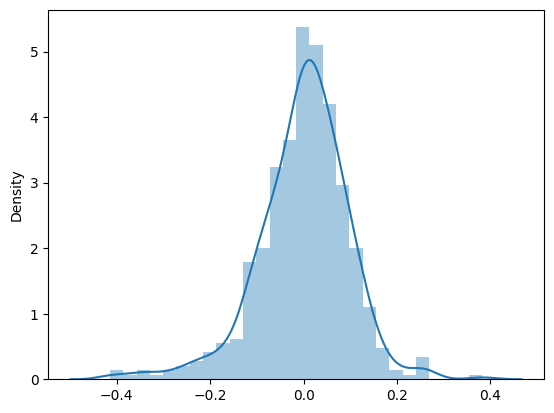

In [61]:
res = y_m1_train - y_m1_train_pred
sns.distplot(res)

<Axes: ylabel='Density'>

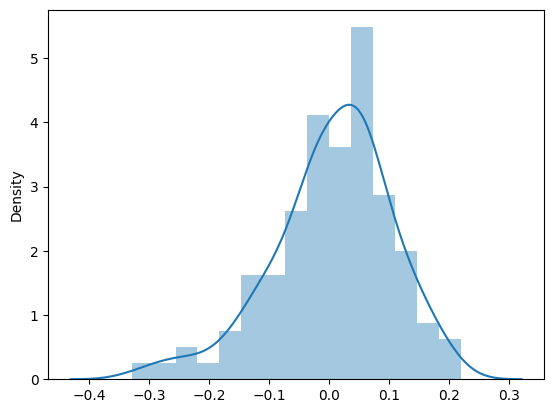

In [62]:
res = y_m1_test - y_m1_test_pred
sns.distplot(res)

#### R² score of predicted data

<a id="r2_score_prediction">

In [63]:
r2_score(y_m1_test, y_m1_test_pred)

0.7929894625156476

#### Summary

R² of predicted data on **test data set** is 0.79 which is in the acceptable range for the model, and the residue (error) is **normal distributed** for train as well test dataset.

This model is performing well on all the usual parameters / checks.

## Model using months

In the following modelling, we will use months instead of seasons variables to see if we get better accuracy then earlier model.


In [64]:
# generate dummy variables for months
data = pd.get_dummies(data,columns=["mnth"], drop_first=True,prefix="mn")

In [65]:
data.head()

,dteday,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,...,mn_3,mn_4,mn_5,mn_6,mn_7,mn_8,mn_9,mn_10,mn_11,mn_12
0,01-01-2018,0,0,6,0,14.110847,18.18125,80.5833,10.749882,985,...,0,0,0,0,0,0,0,0,0,0
1,02-01-2018,0,0,0,0,14.902598,17.68695,69.6087,16.652113,801,...,0,0,0,0,0,0,0,0,0,0
2,03-01-2018,0,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,...,0,0,0,0,0,0,0,0,0,0
3,04-01-2018,0,0,2,1,8.200000,10.60610,59.0435,10.739832,1562,...,0,0,0,0,0,0,0,0,0,0
4,05-01-2018,0,0,3,1,9.305237,11.46350,43.6957,12.522300,1600,...,0,0,0,0,0,0,0,0,0,0


In [66]:
model_2 = data[['yr', 'mn_2', 'mn_3', 'mn_4', 'mn_5', 'mn_6', 'mn_7', 'mn_8', 'mn_9', 'mn_10', 'mn_11', 'mn_12' ,'w_light_snow_rain','w_misty', 'atemp','hum','windspeed', 'workingday','cnt']]

In [67]:
model_2.head()

,yr,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,mn_8,mn_9,mn_10,mn_11,mn_12,w_light_snow_rain,w_misty,atemp,hum,windspeed,workingday,cnt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,18.18125,80.5833,10.749882,0,985
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17.68695,69.6087,16.652113,0,801
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.47025,43.7273,16.636703,1,1349
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.60610,59.0435,10.739832,1,1562
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.46350,43.6957,12.522300,1,1600


In [68]:
(m2_train,m2_test) = train_test_split(model_2,train_size=0.7,random_state=100)
m2_train.describe()

,yr,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,mn_8,mn_9,mn_10,mn_11,mn_12,w_light_snow_rain,w_misty,atemp,hum,windspeed,workingday,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.066667,0.098039,0.078431,0.084314,0.076471,0.076471,0.096078,0.080392,0.084314,0.086275,0.084314,0.029412,0.345098,23.500287,63.123710,12.834912,0.676471,4485.337255
std,0.500429,0.249689,0.297660,0.269113,0.278131,0.266010,0.266010,0.294988,0.272166,0.278131,0.281045,0.278131,0.169124,0.475867,8.090963,14.153170,5.292031,0.468282,1950.666077
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.953480,0.000000,2.834381,0.000000,22.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.603063,52.270825,9.041918,0.000000,3120.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.131150,63.437500,12.083182,1.000000,4530.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,30.177700,73.250025,15.750879,1.000000,5973.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,42.044800,97.041700,34.000021,1.000000,8714.000000


In [69]:
scaler = MinMaxScaler()
num_vars = ['atemp','hum','windspeed','cnt']
m2_train[num_vars] = scaler.fit_transform(m2_train[num_vars])

In [70]:
m2_train.describe()

,yr,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,mn_8,mn_9,mn_10,mn_11,mn_12,w_light_snow_rain,w_misty,atemp,hum,windspeed,workingday,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.066667,0.098039,0.078431,0.084314,0.076471,0.076471,0.096078,0.080392,0.084314,0.086275,0.084314,0.029412,0.345098,0.513156,0.650480,0.320883,0.676471,0.513499
std,0.500429,0.249689,0.297660,0.269113,0.278131,0.266010,0.266010,0.294988,0.272166,0.278131,0.281045,0.278131,0.169124,0.475867,0.212410,0.145846,0.169803,0.468282,0.224421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.332086,0.538643,0.199179,0.000000,0.356420
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.529718,0.653714,0.296763,1.000000,0.518638
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.688457,0.754830,0.414447,1.000000,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


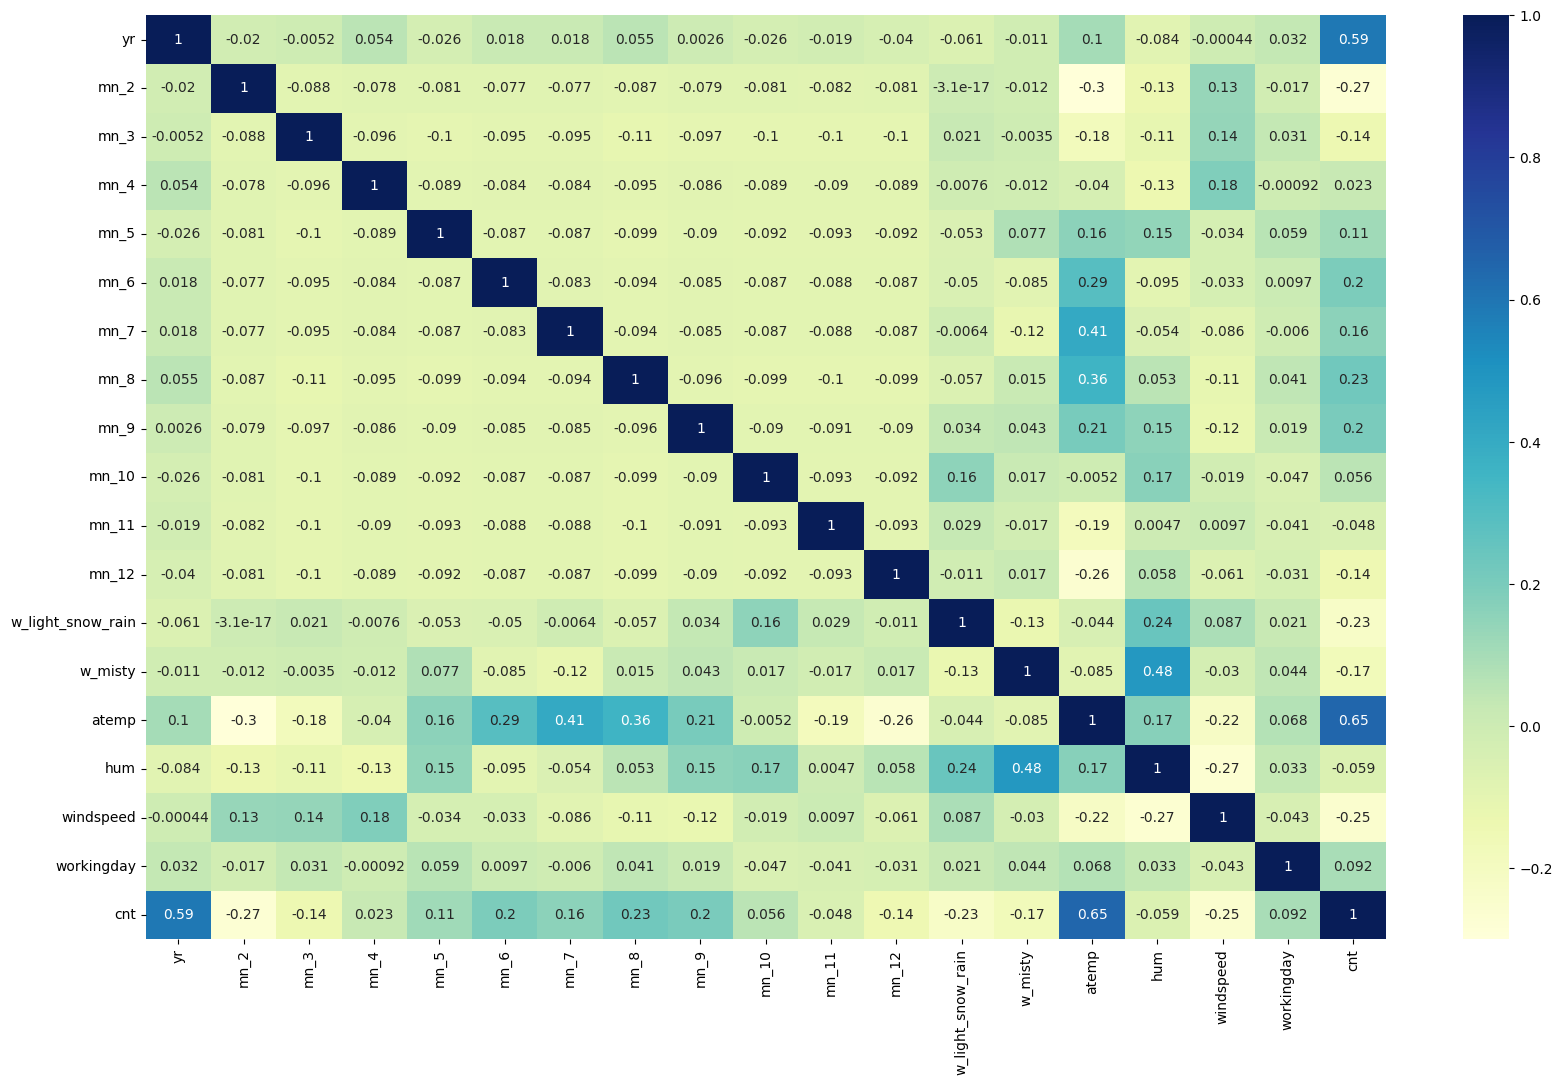

In [71]:
plt.figure(figsize=(20,12))
sns.heatmap(m2_train.corr(),annot=True,cmap="YlGnBu")
plt.show()

### Performing RFE Analysis

Since there are 11 month variables, we could employ RFE analysis to find out their importance in the model which we are going to refine in next steps.

We will drop the weakly correlated variables like hum (humidity) and workingday from our model RFE analysis.

In [72]:
X_m2_train = m2_train[['yr', 'mn_2', 'mn_3', 'mn_4', 'mn_5', 'mn_6', 'mn_7', 'mn_8', 'mn_9', 'mn_10', 'mn_11', 'mn_12' ,'w_light_snow_rain','w_misty', 'atemp','windspeed']]
y_m2_train = m2_train['cnt']

In [73]:
lm = LinearRegression()
lm.fit(X_m2_train,y_m2_train)
rfe = RFE(estimator=lm,n_features_to_select=16)
rfe=rfe.fit(X_m2_train,y_m2_train)

In [74]:
list(zip(X_m2_train.columns,rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('mn_2', True, 1),
 ('mn_3', True, 1),
 ('mn_4', True, 1),
 ('mn_5', True, 1),
 ('mn_6', True, 1),
 ('mn_7', True, 1),
 ('mn_8', True, 1),
 ('mn_9', True, 1),
 ('mn_10', True, 1),
 ('mn_11', True, 1),
 ('mn_12', True, 1),
 ('w_light_snow_rain', True, 1),
 ('w_misty', True, 1),
 ('atemp', True, 1),
 ('windspeed', True, 1)]

#### RFE Summary

RFE indicates that all the 16 variables are important ones and should be considered. 

### With months, weathers, temp variables -  LR Model A2 

In [75]:
X_m2_train_sm = sm.add_constant(X_m2_train)
lr = sm.OLS(y_m2_train,X_m2_train_sm)
lr_model = lr.fit()
lr_model.params

const                0.136164
yr                   0.239429
mn_2                 0.037042
mn_3                 0.121044
mn_4                 0.177468
mn_5                 0.207157
mn_6                 0.200542
mn_7                 0.139411
mn_8                 0.191852
mn_9                 0.253934
mn_10                0.233590
mn_11                0.178610
mn_12                0.127459
w_light_snow_rain   -0.278685
w_misty             -0.076550
atemp                0.363035
windspeed           -0.163152
dtype: float64

In [76]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     140.7
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          5.26e-172
Time:                        20:20:08   Log-Likelihood:                 476.63
No. Observations:                 510   AIC:                            -919.3
Df Residuals:                     493   BIC:                            -847.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1362      0.021      6.589      0.000       0.096       0.177
yr                    0.2394      0.009     27.558      0.000       0.222       0.256
mn_2                  0.0370      0.022      1.655      0.099      -0.007       0.081
mn_3                  0.1210      0.022      5.500      0.000       0.078       0.164
mn_4                  0.1775      0.025      7.098      0.000       0.128       0.227
mn_5                  0.2072      0.028      7.275      0.000       0.151       0.263
mn_6                  0.2005      0.032      6.214      0.000       0.137       0.264
mn_7                  0.1394      0.035      3.952      0.000       0.070       0.209
mn_8                  0.1919      0.032      5.990      0.000       0.129       0.255
mn_9                  0.2539      0.030      8.535      0.000       0.195       0.312
mn_10                 0.2336      0.025      9.241      0.000       0.184       0.283
mn_11                 0.1786      0.022      8.046      0.000       0.135       0.222
mn_12                 0.1275      0.021      5.944      0.000       0.085       0.170
w_light_snow_rain    -0.2787      0.026    -10.645      0.000      -0.330      -0.227
w_misty              -0.0766      0.009     -8.282      0.000      -0.095      -0.058
atemp                 0.3630      0.047      7.764      0.000       0.271       0.455
windspeed            -0.1632      0.027     -6.050      0.000      -0.216      -0.110
==============================================================================
Omnibus:                       77.387   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.076
Skew:                          -0.771   Prob(JB):                     4.36e-43
Kurtosis:                       5.609   Cond. No.                         27.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF

In [77]:
vif=pd.DataFrame()
vif['Features']=X_m2_train.columns
vif['VIF']= [variance_inflation_factor(X_m2_train.values,i) for i in range(X_m2_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
14,atemp,27.50
7,mn_8,5.36
6,mn_7,5.16
5,mn_6,4.34
15,windspeed,4.01
8,mn_9,3.88
4,mn_5,3.73
9,mn_10,2.89
3,mn_4,2.65
2,mn_3,2.47


#### VIF Analysis

atemp is highly correlated to other independent variables, so lets drop it and see how the model performs.


### Without temperature - LR Model B2

In [78]:
X_m2_train = m2_train[['yr', 'mn_2', 'mn_3', 'mn_4', 'mn_5', 'mn_6', 'mn_7', 'mn_8', 'mn_9', 'mn_10', 'mn_11', 'mn_12' ,'w_light_snow_rain','w_misty', 'windspeed']]
y_m2_train = m2_train['cnt']
X_m2_train_sm = sm.add_constant(X_m2_train)
lr = sm.OLS(y_m2_train,X_m2_train_sm)
lr_model = lr.fit()
lr_model.params

const                0.216811
yr                   0.248072
mn_2                 0.064435
mn_3                 0.192678
mn_4                 0.279989
mn_5                 0.359578
mn_6                 0.388960
mn_7                 0.357270
mn_8                 0.385733
mn_9                 0.417481
mn_10                0.344622
mn_11                0.243772
mn_12                0.171965
w_light_snow_rain   -0.288119
w_misty             -0.080470
windspeed           -0.189435
dtype: float64

In [79]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     130.4
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          8.39e-161
Time:                        20:20:09   Log-Likelihood:                 447.22
No. Observations:                 510   AIC:                            -862.4
Df Residuals:                     494   BIC:                            -794.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2168      0.019     11.468      0.000       0.180       0.254
yr                    0.2481      0.009     27.204      0.000       0.230       0.266
mn_2                  0.0644      0.023      2.755      0.006       0.018       0.110
mn_3                  0.1927      0.021      9.111      0.000       0.151       0.234
mn_4                  0.2800      0.022     12.461      0.000       0.236       0.324
mn_5                  0.3596      0.022     16.475      0.000       0.317       0.402
mn_6                  0.3890      0.023     17.275      0.000       0.345       0.433
mn_7                  0.3573      0.023     15.792      0.000       0.313       0.402
mn_8                  0.3857      0.021     18.171      0.000       0.344       0.427
mn_9                  0.4175      0.022     18.774      0.000       0.374       0.461
mn_10                 0.3446      0.022     15.624      0.000       0.301       0.388
mn_11                 0.2438      0.022     11.208      0.000       0.201       0.287
mn_12                 0.1720      0.022      7.864      0.000       0.129       0.215
w_light_snow_rain    -0.2881      0.028    -10.411      0.000      -0.342      -0.234
w_misty              -0.0805      0.010     -8.239      0.000      -0.100      -0.061
windspeed            -0.1894      0.028     -6.691      0.000      -0.245      -0.134
==============================================================================
Omnibus:                       81.228   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.380
Skew:                          -0.741   Prob(JB):                     7.04e-55
Kurtosis:                       6.088   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### VIF

In [80]:
vif=pd.DataFrame()
vif['Features']=X_m2_train.columns
vif['VIF']= [variance_inflation_factor(X_m2_train.values,i) for i in range(X_m2_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
14,windspeed,3.91
0,yr,1.94
13,w_misty,1.51
2,mn_3,1.50
3,mn_4,1.47
1,mn_2,1.35
9,mn_10,1.34
10,mn_11,1.32
7,mn_8,1.30
4,mn_5,1.30


#### Summary

We were able to address the multicollinearity by removing atemp variable. However The model's R² has gone down a bit and despite having 15 independent variables R² is not better compared to **LR Model B**. 

Hence the approach of building model using the months as independent variable is not pragmatic and the resultant model will not be only more complex but also not so accurate as the [**LR Model B**](#lr_modelb).

# Exercise Summary

After analyzing the data and building multiple linear regression models using various combinations of independent variables, we have found the model which is using the least no. of independent variables (i.e. 6) and has  R² and adjusted R² more than 0.8.

The R² score on predicted value based on test data set is 0.79, please refer to [R² score of predicted data](#r2_score_prediction)

Following are the summary points,

* [LR Model B](#lr_modelb) is the finalized model.
* It uses : ```yr, atemp, s_spring, w_light_snow_rain, w_misty, windspeed ```
* The coeffecients of these independent variables are,
```
const                0.310191
yr                   0.236811
atemp                0.388947
s_spring            -0.152877
w_light_snow_rain   -0.267825
w_misty             -0.074380
windspeed           -0.1
```

* There is an intercept of 0.310191
* It is important to note that year and "feels-like" temperature have positive correlation with bike rental, and that correlates to the uptick in rentals in year 2019 (which is represent as 1 in the dataset) compared to 2018 (represented as 0)
    * Higher the temperature, people would like to rent more bikes because it might be a conducive weather for outdoor activities.
* The weather conditions like raining, snowing, and windy would usually discourage the rental activities.
* Except spring no other seasons have any major impact on outcome variable (i.e. cnt).

Based on data, the regression model is **better off** to be relying on temperature, weather, season and year data compared to months and year variables. 
